In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from scipy.sparse import csc_matrix, lil_matrix
from cv2 import VideoWriter, VideoWriter_fourcc
import cv2
from tqdm import tqdm_notebook

In [2]:
def get_bgr_img(array):
    fig = Figure()
    canvas = FigureCanvas(fig)
    subplot = fig.subplots()
    fig.colorbar(subplot.imshow(array))
    fig.gca().invert_yaxis()
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [3]:
type1_houses = [(69,111), (69,264), (138,12), (138,165), (192,111), (192,264), (261,12), (261,165)]
def in_type1_house(x, y):
    def _in_type1_house(hx, hy, x, y):
        return (hx < x and x < hx + 18 and hy < y and y < hy + 18)
    for hx, hy in type1_houses:
        if _in_type1_house(hx, hy, x, y):
            return True
    return False

In [4]:
type2_houses = [(69,12), (69,165), (192,12), (192,165)]
def in_type2_house(x, y):
    def _in_type2_house(hx, hy, x, y):
        return (hx < x < hx + 18 and hy < y < hy + 78) or (hx < x < hx + 30 and hy < y < hy + 18)
    for hx, hy in type2_houses:
        if _in_type2_house(hx, hy, x, y):
            return True
    return False

In [5]:
type3_houses = [(138,51), (138,204), (261,51), (261,204)]
def in_type3_house(x, y):
    def _in_type3_house(hx, hy, x, y):
        return (hx < x < hx + 18 and hy < y < hy + 78) or (hx - 12 < x < hx + 18 and hy + 60 < y < hy + 78)
    for hx, hy in type3_houses:
        if _in_type3_house(hx, hy, x, y):
            return True
    return False

In [6]:
def in_house(x, y):
    return in_type1_house(x, y) or in_type2_house(x, y) or in_type3_house(x, y)

In [7]:
def edge_condition(x, y, M):
    k = 300 / M
    nx = x * k
    ny = y * k
    return in_house(nx, ny) or x > M - 1 or y > M - 1 or y <= 0

In [8]:
def solve(M = 300, eps = 1e-8, iters = 500000, writeVideo=True):  
    k = 0.5
    l1 = 1
    l2 = 0
    
    tau = 1 / (4 * k * M * M)
    h = 1 / M
    coeffs = [
            1 - 4 * tau * k / (h**2),
            tau * (k / (h**2) - l1 / (2 * h)),
            tau * (k / (h**2) + l1 / (2 * h)),
            tau * (k / (h**2) - l2 / (2 * h)),
            tau * (k / (h**2) + l2 / (2 * h))
        ]
    dx = [0, 1, -1, 0, 0]
    dy = [0, 0, 0, 1, -1]
    
    MM = M * M
    
    A = lil_matrix((MM, MM), dtype=np.float64)
    b = np.zeros(MM)
    
    for x in range(M): 
        for y in range(M):
            i = x * M + y
            if x == 0:
                A[i, i] = 1
                continue
            A[i, i] = coeffs[0]
            if edge_condition(x, y, M):
                continue
            for d in range(1, 5):
                nx = x + dx[d]
                ny = y + dy[d]
                if nx == 0:
                    b[i] += coeffs[d]
                elif edge_condition(nx, ny, M):
                    A[i, i] += coeffs[d]
                else:
                    A[i, nx * M + ny] = coeffs[d]

    A = csc_matrix(A)
    u = np.zeros(MM)
    u[0:M] = 1
    
    if writeVideo:
        img = get_bgr_img(u.reshape((M, M)).T)
        width, height = img.shape[:-1]
        vid = VideoWriter(f'diffusion-eps{eps}-M{M}.avi', VideoWriter_fourcc(*"XVID"), 10.0, (height, width))
    
    for i in tqdm_notebook(range(iters)):
        u_new = A * u + b
        error = np.max(np.abs((u_new - u) / np.maximum(1, u)))
        u = u_new
        if i % 500 == 0 and writeVideo:
            vid.write(get_bgr_img(u.reshape((M, M)).T))
        if error < eps:
            print("Epsilon stop, iter:", i)
            break
    if writeVideo:
        vid.release()
        
    res = u.reshape((M, M)).T
    fig = plt.imshow(res)
    plt.colorbar(fig)
    plt.gca().invert_yaxis()
    plt.show()
    return res

Epsilon stop, iter: 3914


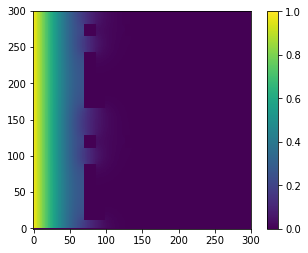

In [9]:
res = solve(M = 300, eps = 1e-4)

Epsilon stop, iter: 36163


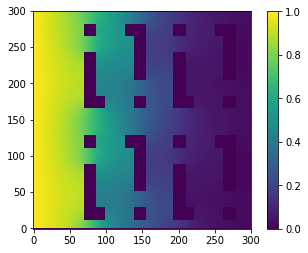

In [10]:
res = solve(M = 300, eps = 1e-5)

Epsilon stop, iter: 303118


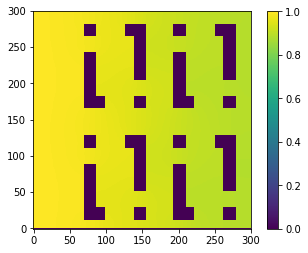

In [11]:
res = solve(M = 300, eps = 1e-6)